In [1]:
import os,sys
sys.path.append('./PTS')

import numpy as np
from run_skirt import get_lightcurve
from astropy import units as u
from astropy import constants as c
from scipy import optimize as opt
import datetime
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [2]:
# Define Target and Folders

target = 'ASASSN-15lh'
distance = 1171*u.Mpc
peak = 57250

lightcurve = True

today = str(datetime.date.today()+datetime.timedelta(days=3))
DATAFILES = "data/"+target+'/'
OUTFILES = "results/"+target+'/'+today+'/'
PLOTFILES = "plots/"+target+'/'+today+'/'
if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])
log=open(OUTFILES+'log.txt','a')

In [3]:
# Define Simulation Parameters

timesteps = 10         # amount of timesteps considered by SKIRT
output_tsteps = 100    # desired amount of timesteps after interpolation

amin = 1e-4            # smallest dust grain size in micron, this is the lowest value supported by SKIRT
amax = 1               # largest dust grain size in micron
grainpowerlaw = 3      # the powerlaw distribution of mass along different grain sizes
alpha = 1              # radial dust mass density powerlaw
total_mass = 10         # of the dust in MSun
Si = 0.                # silicates fraction (as opposed to graphites)
Lbol_factor = 0.05       # bolometric correction factor

centralBin = 0.01      # size of central grid section in pc
outer = 5              # outer radius of the dust shell in pc
spaceBins = 100        # number of spatial shells in the radial direction

In [6]:
# Load the TDE lightcurve
L=np.genfromtxt(DATAFILES+target+'_lc_neutral.dat',skip_header=1).T[0:3]
W1=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[:3]
W2=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[3:]

# Central wavelength for the 2 WISE filters
wl_w1=3.368*u.um
wl_w2=4.618*u.um

# Reduce the amount of timesteps to 'timesteps', with a number of them concenrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))
L_data=binning(t_data,L[0],L[1],L[2])
t_data=L_data[0]

# We will use a constant temperature of 2e4 K here, 
# as our data set does not provide a very accurate read on the TDE's temperature evolution
T_data = np.array((L_data[0],[2e4]*len(L_data[2])))

output_t=np.linspace(np.min(t_data),np.max(np.concatenate([W1[0],W2[0]])),output_tsteps)

19/10/2023 11:22:36.076 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
19/10/2023 11:22:36.076 !   return _methods._mean(a, axis=axis, dtype=dtype,
19/10/2023 11:22:36.082 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
19/10/2023 11:22:36.082 !   ret = ret.dtype.type(ret / rcount)
19/10/2023 11:22:36.085 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
19/10/2023 11:22:36.085 !   ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
19/10/2023 11:22:36.088 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
19/10/2023 11:22:36.088 !   arrmean = um.true_divide(arrmean, div, out=arrmean,
19/10/2023 11:22:36.094 

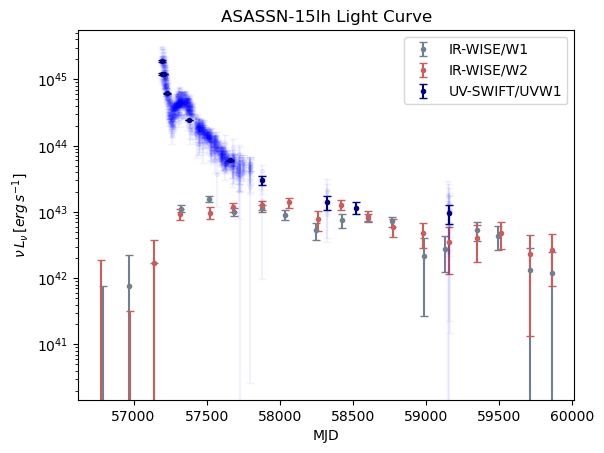

In [7]:
# Plotting the input data
if lightcurve:
    plt.figure()
    plt.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=np.abs((c.c/wl_w1).to(u.Hz).value*W1[2]),\
                 fmt='.',capsize=3,color='slategrey',label='IR-WISE/W1')
    plt.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=np.abs((c.c/wl_w2).to(u.Hz).value*W2[2]),\
                 fmt='.',capsize=3,color='indianred',label='IR-WISE/W2')
    plt.errorbar(L[0],L[1],yerr=L[2],fmt='.',alpha=0.05,capsize=3,color='blue')
    plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
    plt.xlabel('MJD')
    plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
    plt.title(target+' Light Curve')
    plt.yscale('log')
    plt.legend()
    plt.savefig(OUTFILES+target+'_lightcurve.pdf')
    plt.show()

FWHM 235.48200450309494


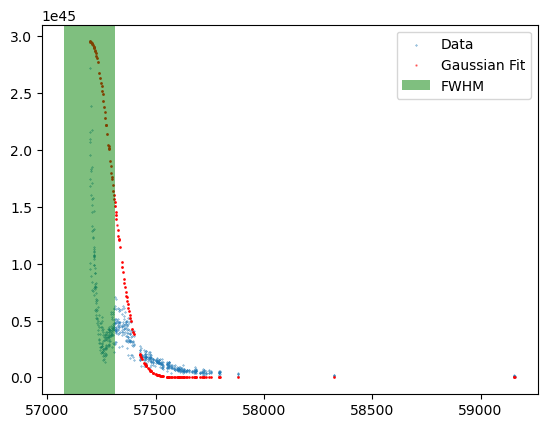

FWHM 41.38972293902923


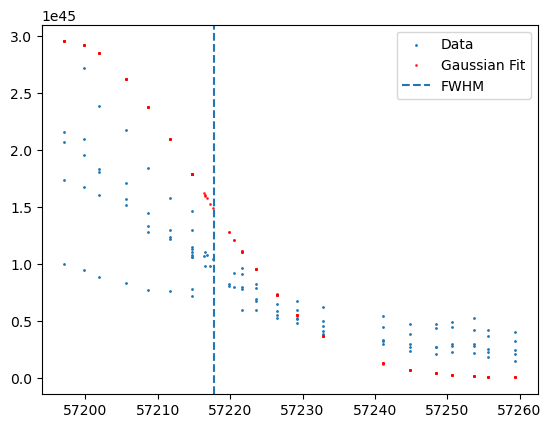

In [8]:
# This implementation cannot track dust survival time
# Therefore dust sublimation is based on the lightcurve's FWHM
# We find this here by fitting a gaussian

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))
N = len(L[0,:])
X = L[0,:]
Y = L[1,:]

p0 = [L[0,np.argmax(L[1,:])],100] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=0.1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=0.5,alpha=0.5, color='r',label='Gaussian Fit')
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.5,label='FWHM')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()


# Looking at the first plot shows that the second peak in 15lh's lightcurve is dictating the FWHM
# As this is undesirable, we will not use this part for the fit
def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

mask = (L[0]<57260)
N = len(L[0,mask])
X = L[0,mask]
Y = L[1,mask]

p0 = [L[0,np.argmax(L[1,:])],L[0,np.argmin(np.abs(L[1]-0.5*np.max(L[1])))]-L[0,np.argmax(L[1,:])]] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=1,alpha=0.75, color='r',label='Gaussian Fit')
#plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.25,label='FWHM')
plt.axvline(fit_mu+FWHM/2, label='FWHM', linestyle='dashed')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()

In [ ]:
# Start the run
if Si!=False:
    print('x')
    lightcurve,wavelengths,temp,radius=get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor\
                                                                ,L_data[2]*Lbol_factor))\
                                                      ,T_data,t_data,output_t,\
                                                      [centralBin,outer,alpha,total_mass],\
                                                      [amin,amax,grainpowerlaw],FWHM,spaceBins,distance=distance,\
                                                      skiname='TDE_C+Si.ski',Si=Si,prefix=str(today),\
                                                      OUTFILES=OUTFILES,plot_SED=True,SKIRTpath='SKIRT/release/SKIRT/main/skirt')
else:
    lightcurve,wavelengths,temp,radius=get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                ,L_data[2]*Lbol_factor)) \
                                                      ,T_data,t_data,output_t \
                                                      ,[centralBin,outer,alpha,total_mass] \
                                                      ,[amin,amax,grainpowerlaw],FWHM,spaceBins,distance=distance \
                                                      ,skiname='TDE.ski',Si=Si,prefix=str(today) \
                                                      ,OUTFILES=OUTFILES,plot_SED=True,SKIRTpath='SKIRT/release/SKIRT/main/skirt')

SKIRT Runs:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

19/10/2023 11:23:47.939   Welcome to SKIRT v9.0 (git 06136cf built on 19/10/2023 at 10:44:59)
19/10/2023 11:23:47.939   Running on remon-lenovo for remon
19/10/2023 11:23:47.939   Constructing a simulation from ski file '/home/remon/DustEcho2/results/ASASSN-15lh/2023-10-22/57197/torus.ski'...
19/10/2023 11:24:11.351 - Finished setup in 22.9 s.
19/10/2023 11:24:11.939 - Finished setup output in 0.6 s.
19/10/2023 11:24:21.150 - Finished primary emission iteration 1 in 9.2 s.
19/10/2023 11:24:30.309 - Finished primary emission iteration 2 in 9.2 s.
19/10/2023 11:24:39.410 - Finished primary emission iteration 3 in 9.1 s.
19/10/2023 11:24:48.441 - Finished primary emission iteration 4 in 9.0 s.
19/10/2023 11:25:00.434 - Finished primary emission iteration 5 in 12.0 s.
19/10/2023 11:25:11.386 - Finished primary emission iteration 6 in 11.0 s.
19/10/2023 11:25:21.966 - Finished primary emission iteration 7 in 10.6 s.
19/10/2023 11:25:33.104 - Finished primary emission iteration 8 in 11.1 s.


SKIRT Runs:  10%|██████████▋                                                                                                | 1/10 [04:35<41:19, 275.55s/it]

In [17]:
# indices corresponding to the WISE filter wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))

# Convert and Save
luminosity=FluxtoLum(lightcurve,distance=distance)
coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]
log.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
log.write('\n')
if os.path.isdir(OUTFILES+'GridSearch/')==False:
    os.makedirs(OUTFILES+'GridSearch/')
if os.path.isdir(PLOTFILES+'/')==False:
    os.makedirs(PLOTFILES+'/')

np.savetxt(OUTFILES+'config.txt',luminosity.value)

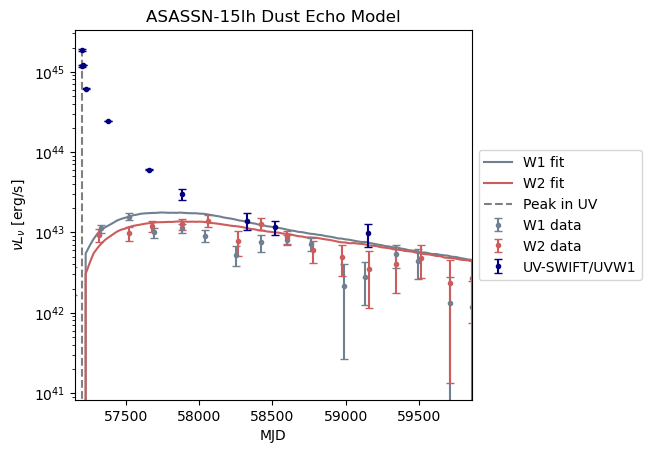

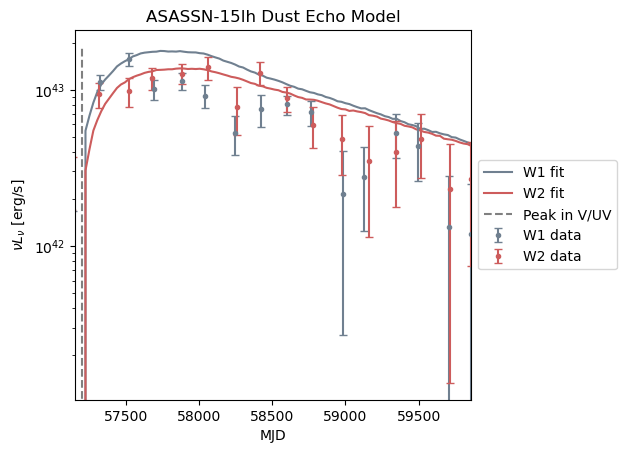

In [18]:
luminosity = luminosity * coveringFactor

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred')
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
ax.plot([t_data[np.argmax(L_data[1,:])]]*2,ax.get_ylim(),linestyle='dashed',color='grey',label='Peak in UV')
ax.set_yscale('log')
ax.set_xlim(peak-100,np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('MJD')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES+'/lightcurve.pdf')

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred')
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.plot([t_data[np.argmax(L_data[1,:])]]*2,ax.get_ylim(),linestyle='dashed',color='grey',label='Peak in V/UV')
ax.set_yscale('log')
ax.set_xlim(peak-100,np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('MJD')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES+'/lightcurve(1).pdf')